# カーネルSVM

## ライブラリーのインポート

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## データセットのインポート

In [2]:
# XORデータセットの生成
np.random.seed(0)
X = np.random.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# yを整数型に変換
y = y.astype(int)

# 特徴量名を定義
feature_names = ['feature1', 'feature2']

## データセットの確認

In [3]:
pd.set_option('display.max_columns', None)
# データフレームに変換
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df.head()

,feature1,feature2,target
0,1.764052,0.400157,0
1,0.978738,2.240893,0
2,1.867558,-0.977278,1
3,0.950088,-0.151357,1
4,-0.103219,0.410599,1


In [4]:
print(f'データの形式：{df.shape}')
print(f'欠損値の数：{df.isnull().sum().sum()}')

データの形式：(200, 3)
欠損値の数：0


## 説明変数と目的変数に分割

In [7]:
# 相関関係の高い2つの特徴量を抽出
select_features = feature_names
X = df.loc[:, select_features].values
y = df.loc[:, 'target'].values

## 訓練データとテストデータに分割

In [8]:
# 全体の30%をテストデータととする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

In [9]:
# 各データセットのラベルの比率
print('入力データセットのyラベルの比率:', np.bincount(y))
print('訓練サブセットのyラベルの比率:', np.bincount(y_train))
print('テストサブセットのyラベルの比率:', np.bincount(y_test))

入力データセットのyラベルの比率: [ 99 101]
訓練サブセットのyラベルの比率: [69 71]
テストサブセットのyラベルの比率: [30 30]


## 特徴量のスケーリング

In [10]:
sc = StandardScaler()
# 訓練データの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 訓練データによるモデルの学習

In [12]:
# 線形SVMのインスタンスを生成
classifier = SVC(kernel='rbf', C=10, gamma=0.10,random_state=0)
# 訓練データをモデルに適合させる
classifier.fit(X_train_std, y_train)

SVC(C=10, gamma=0.1, random_state=0)

## 新しいデータポイントでの予測

In [15]:
# 新しいデータポイントで予測
new_data = [[1.5,4.0]]
pred_label = classifier.predict(sc.transform(new_data))[0]
print(f'予測したクラス:{pred_label}({select_features[pred_label]})')

予測したクラス:1(feature2)


## テストデータで予測

In [16]:
# テストデータで予測を実施
y_pred = classifier.predict(X_test_std)

## モデルの性能評価

In [17]:
# 正分類のデータ点の個数を表示
print(f'正分類のデータ点: {(y_test == y_pred).sum()}個/{len(y_test)}個' )

# 分類の正解率を表示
print(f'Accuracy(Test): {accuracy_score(y_test, y_pred):.3f}')


正分類のデータ点: 54個/60個
Accuracy(Test): 0.900


## 性能評価の可視化

In [18]:
# 訓練データとテストデータの最小値と最大値を計算
def calculate_bounds(X1, X2):
    X1_min, X1_max = X1.min() - (X1.max()-X1.min())/20, X1.max() + (X1.max()-X1.min())/20
    X2_min, X2_max = X2.min() - (X2.max()-X2.min())/20, X2.max() + (X2.max()-X2.min())/20
    return X1_min, X1_max, X2_min, X2_max

In [19]:
def plot_data(ax, X_set, y_set, X1, X2, Z, colors, kind, classifier):
    cmap = ListedColormap(colors[:len(np.unique(y_set))])
    ax.contourf(X1, X2, Z, alpha=0.3, cmap=cmap)
    for idx, feature in enumerate(np.unique(y_set)):
        ax.scatter(x=X_set[y_set == feature, 0], 
                   y=X_set[y_set == feature, 1],
                   alpha=0.5, 
                   color=colors[idx],
                   marker='o', 
                   label=feature, 
                   edgecolor='black')
    ax.set_xlabel(select_features[0])
    ax.set_ylabel(select_features[1])
    ax.set_title(f'{type(classifier).__name__} ({kind})')
    ax.legend(loc='best')

In [20]:
def plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier):
    # マーカーとカラーマップの準備
    colors = ('red', 'blue', 'green')
    
    # スケーリング前の元のデータに変換
    X_train_set, y_train_set = sc.inverse_transform(X_train_std), y_train
    X_test_set, y_test_set = sc.inverse_transform(X_test_std), y_test
    
    # 訓練データとテストデータの範囲を統一
    X_combined = np.vstack((X_train_set, X_test_set))
    X1_min, X1_max, X2_min, X2_max = calculate_bounds(X_combined[:, 0], X_combined[:, 1])
    
    # グリッドポイントの生成
    X1, X2 = np.meshgrid(np.arange(X1_min, X1_max, step=(X1_max - X1_min) / 1000),
                         np.arange(X2_min, X2_max, step=(X2_max - X2_min) / 1000))
    # 各特徴を1次元配列に変換して予測を実行
    Z = classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T))
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(X1.shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # 訓練データとテストデータのプロット
    plot_data(ax[0], X_train_set, y_train_set, X1, X2, Z, colors, "Training set", classifier)
    plot_data(ax[1], X_test_set, y_test_set, X1, X2, Z, colors, "Test set", classifier)
    
    plt.tight_layout()
    plt.show()

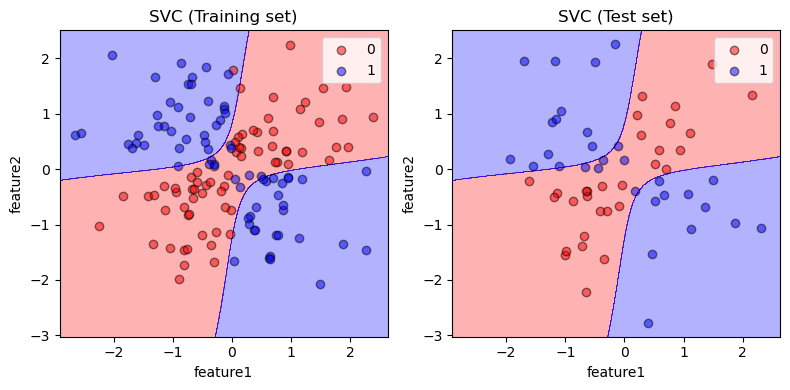

In [21]:
# 決定境界のプロット
if len(select_features) == 2:
    plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier)
else:
    print("特徴量が2個の場合のみプロットが可能です。選択された特徴量の数:", len(select_features))
